In [2]:
!pip install mutagen
!pip install pydub
!pip install librosa
!apt install ffmpeg

     |████████████████████████████████| 218 kB 30.9 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [32]:
import os
from os import listdir
from os.path import isfile, join
import shutil

import sklearn
from sklearn.preprocessing import minmax_scale
import numpy as np
import json
import librosa
import librosa.display
from numpy.lib.utils import source
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from mutagen.mp3 import MP3
from pydub import AudioSegment
from pydub.utils import mediainfo

### برای نمایش ویژگی ها wav خواندن یک آهنگ از هر دسته و تبدیل آن به فرمت

In [23]:
sound = AudioSegment.from_file("/content/drive/MyDrive/ML_course_data_gathering_Arash_Rasouli/بندری/Bandari.mp3")
sound.export("Bandari.wav" , format="wav")

sound = AudioSegment.from_file("/content/drive/MyDrive/ML_course_data_gathering_Arash_Rasouli/ترکی/Iman Parsa - Dard (128).mp3")
sound.export("Torki.wav" , format="wav")

sound = AudioSegment.from_file("/content/drive/MyDrive/ML_course_data_gathering_Arash_Rasouli/لری/02. Bachiyale Mal.mp3")
sound.export("Lori.wav" , format="wav")

sound = AudioSegment.from_file("/content/drive/MyDrive/ML_course_data_gathering_Arash_Rasouli/کردی/nasser_razazi_golbaran 128.mp3")
sound.export("Kordi.wav" , format="wav")

sound = AudioSegment.from_file("/content/drive/MyDrive/ML_course_data_gathering_Arash_Rasouli/گیلکی/Ahmad Ashoorpour - Gul Babare.mp3")
sound.export("Gilaki.wav" , format="wav")

<_io.BufferedRandom name='Gilaki.wav'>

## zero crossing

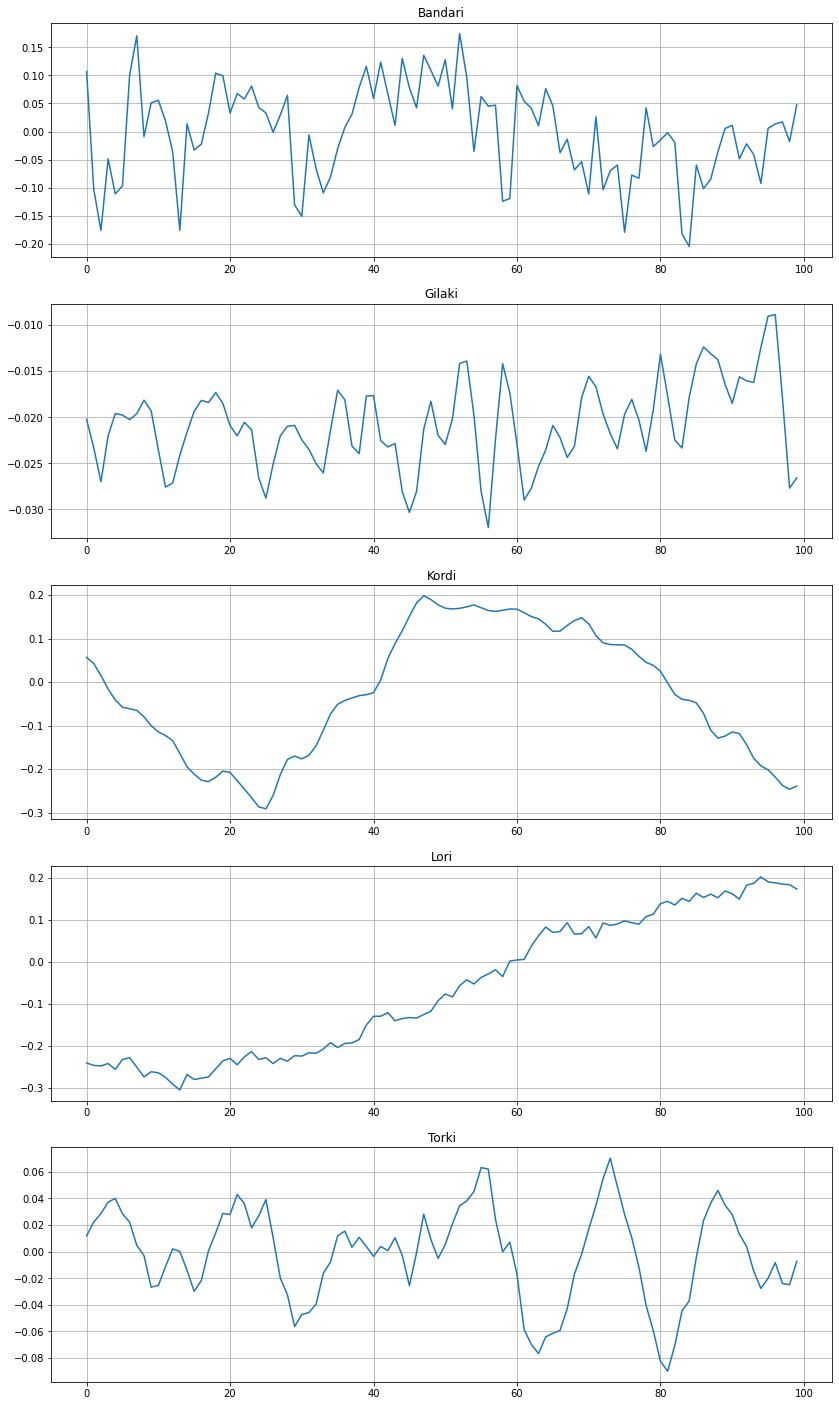

In [26]:
plt.figure(figsize=(14, 25))
categories = ["Bandari", "Gilaki", "Kordi", "Lori", "Torki"]
for i in range(5):
    x, sr = librosa.load("/content/" + categories[i] + ".wav")
    plt.subplot(5, 1, i + 1)
    plt.plot(x[20000:20100])
    plt.grid()
    plt.title(categories[i])
plt.show()

## Spectral Centroid

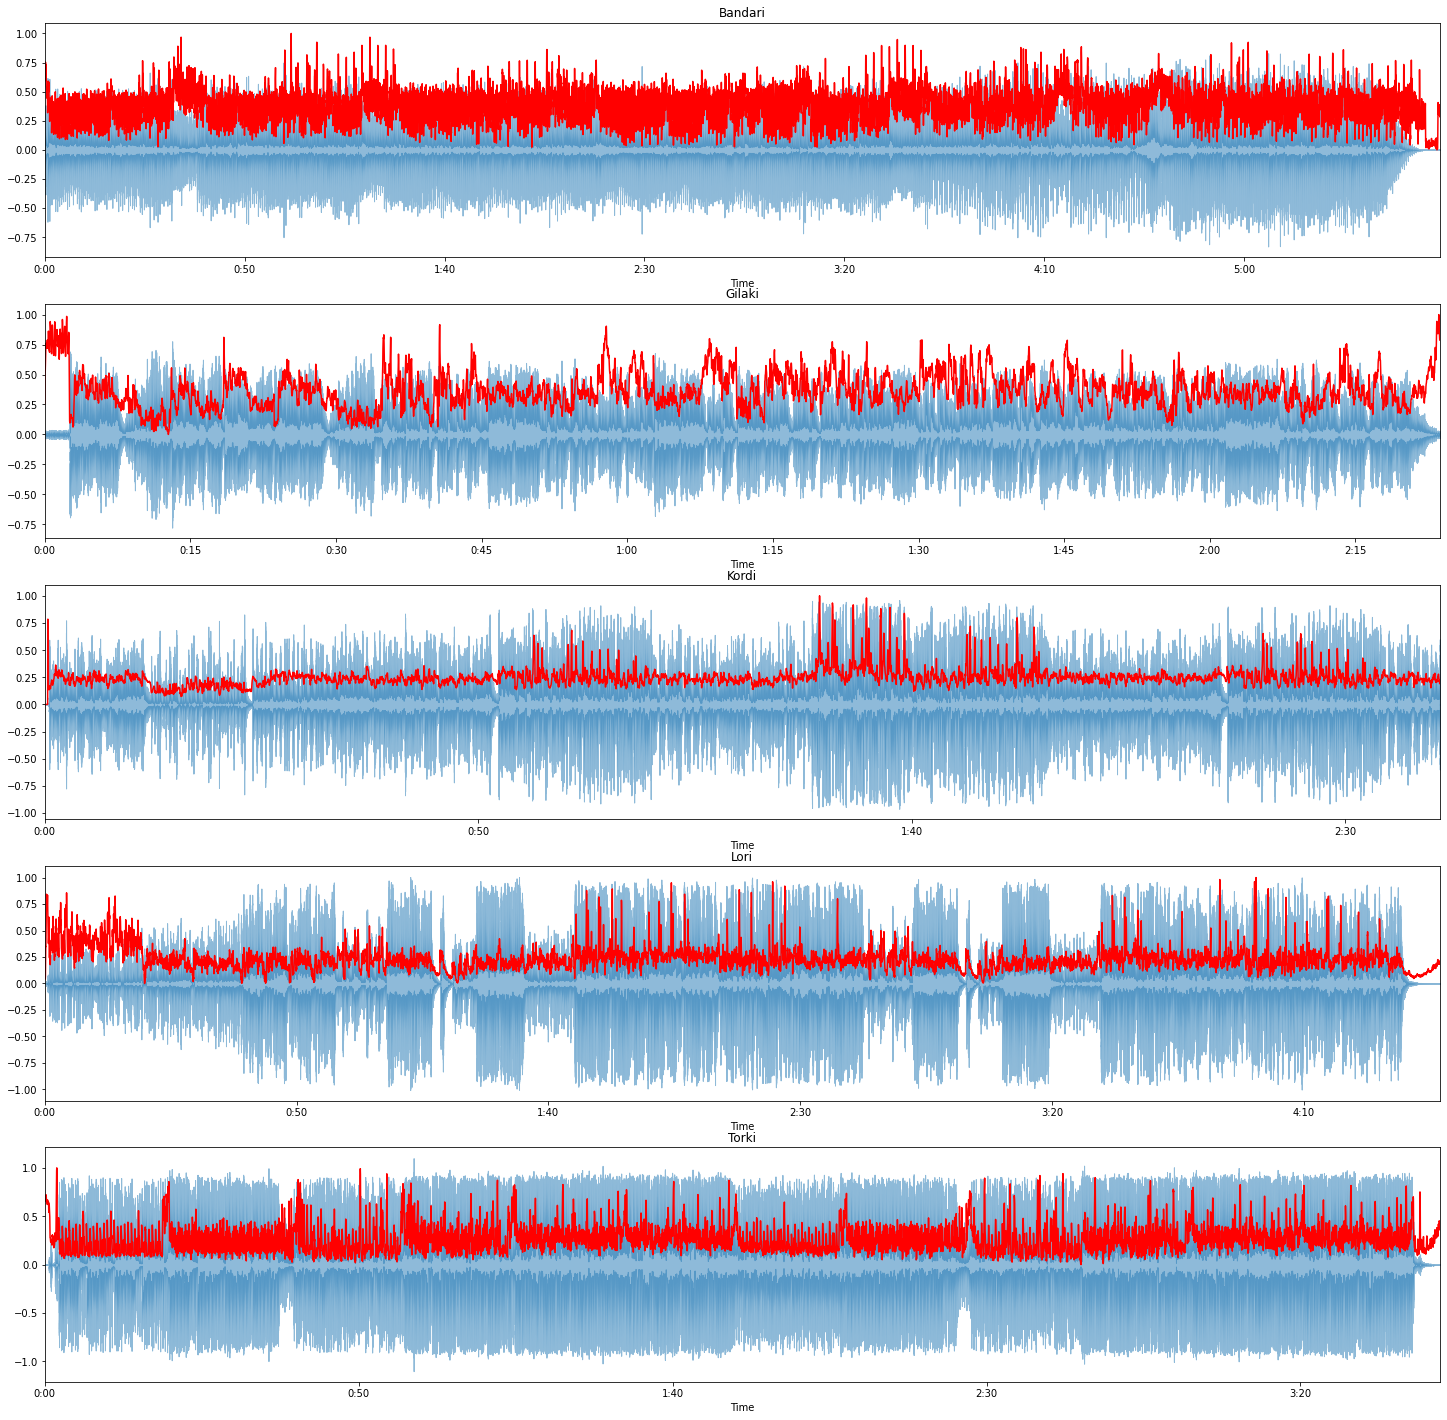

In [62]:
plt.figure(figsize=(25, 25))
categories = ["Bandari", "Gilaki", "Kordi", "Lori", "Torki"]
for i in range(5):
    x, sr = librosa.load("/content/" + categories[i] + ".wav")
    plt.subplot(5, 1, i + 1)
    spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)
    librosa.display.waveplot(x, sr=sr, alpha=0.5)
    plt.plot(t, minmax_scale(spectral_centroids, axis=0), color='r')
    plt.title(categories[i])
plt.show()

## Spectral Rolloff

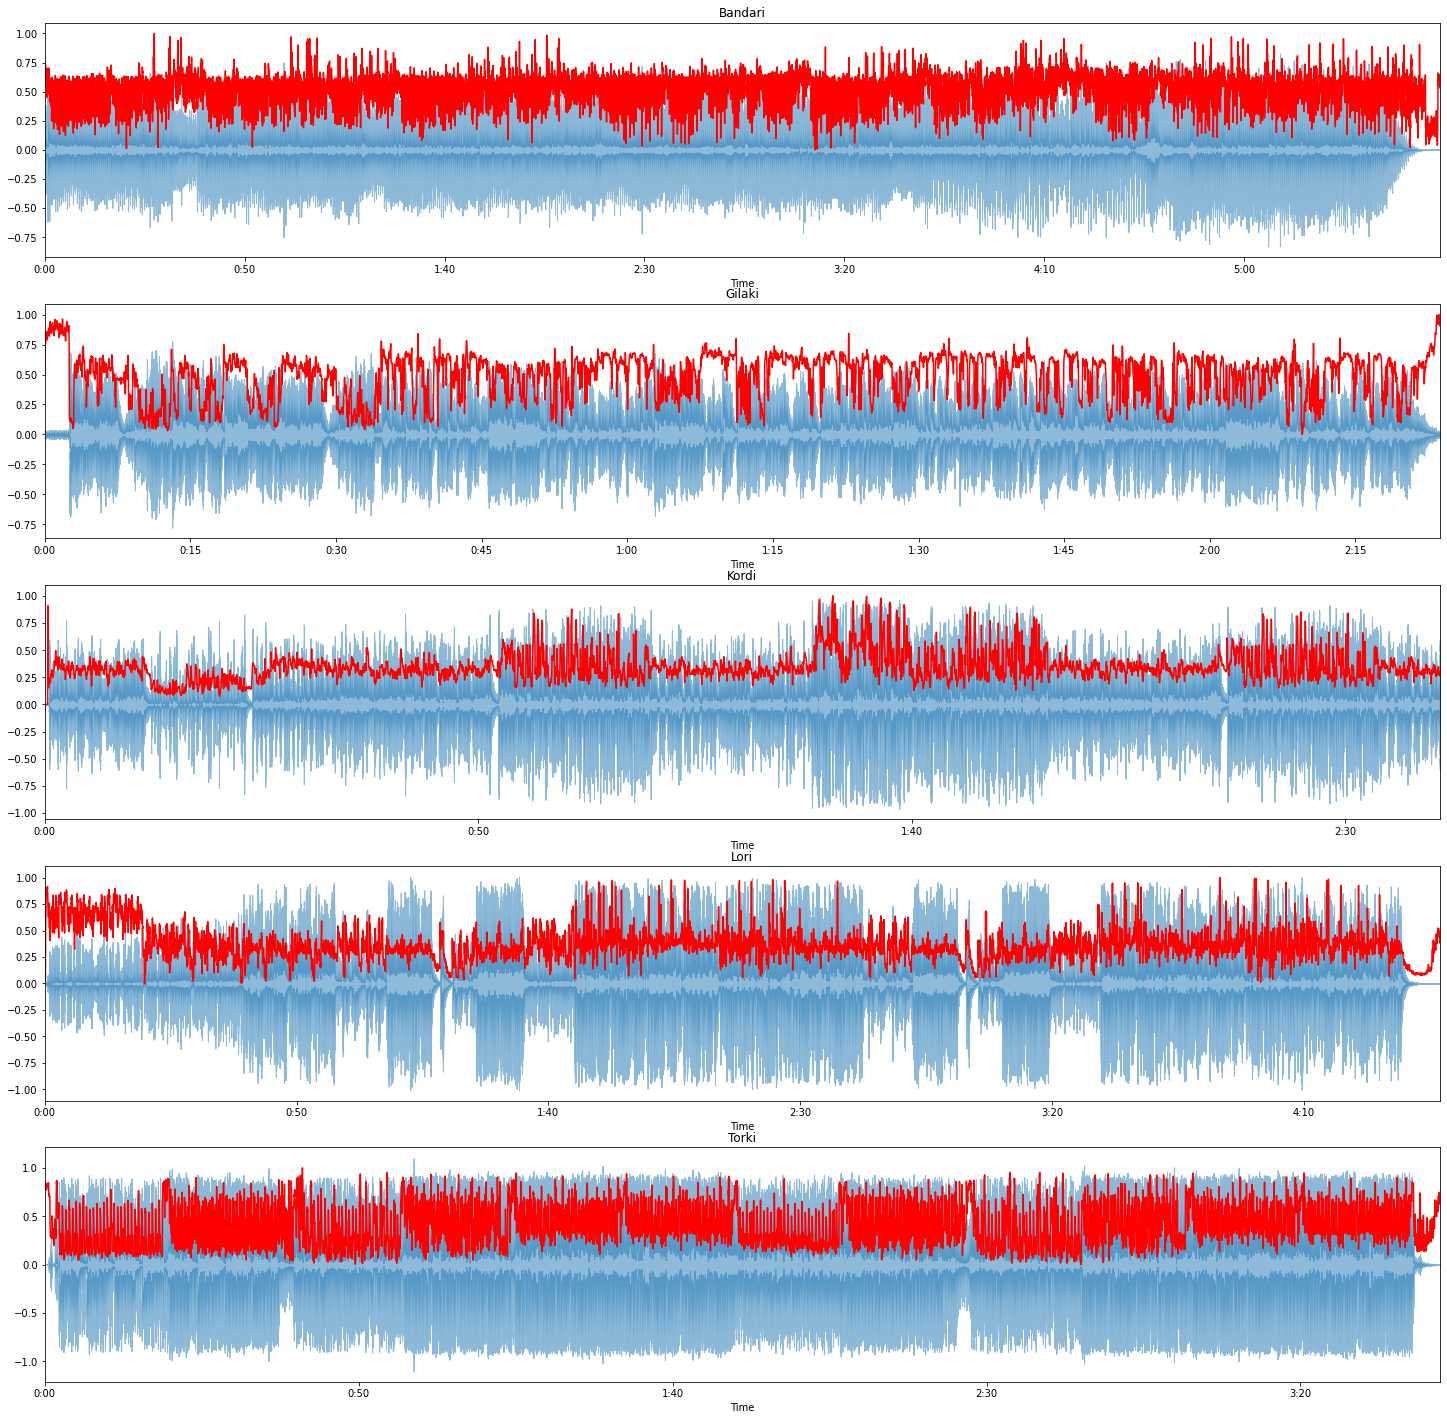

In [65]:
plt.figure(figsize=(25, 25))
categories = ["Bandari", "Gilaki", "Kordi", "Lori", "Torki"]
for i in range(5):
    x, sr = librosa.load("/content/" + categories[i] + ".wav")
    plt.subplot(5, 1, i + 1)
    spectral_rolloff = librosa.feature.spectral_rolloff(x, sr=sr)[0]
    frames = range(len(spectral_rolloff))
    t = librosa.frames_to_time(frames)
    librosa.display.waveplot(x, sr=sr, alpha=0.5)
    plt.plot(t, minmax_scale(spectral_rolloff), color='r')
    plt.title(categories[i])
plt.show()

## Chroma Frequencies

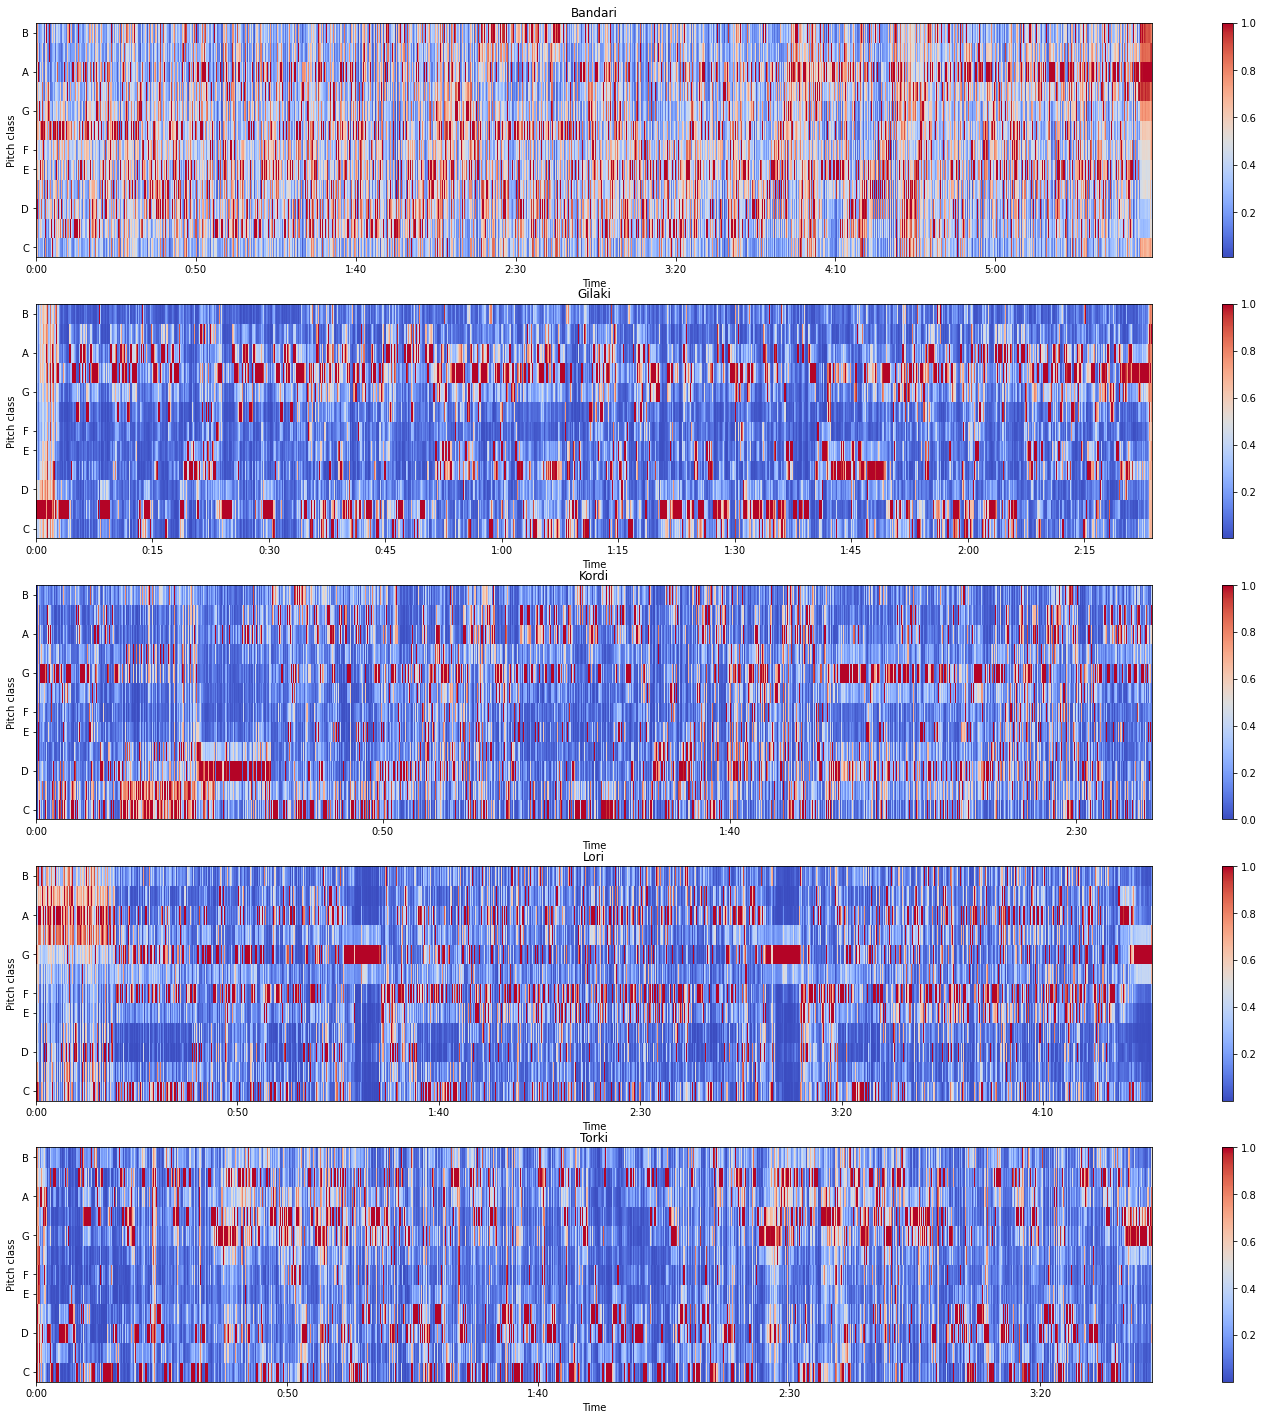

In [71]:
plt.figure(figsize=(25, 25))
categories = ["Bandari", "Gilaki", "Kordi", "Lori", "Torki"]
for i in range(5):
    x, sr = librosa.load("/content/" + categories[i] + ".wav")
    plt.subplot(5, 1, i + 1)
    chromagram = librosa.feature.chroma_stft(x, sr=sr)
    img = librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', cmap='coolwarm')
    plt.colorbar(img)
    plt.title(categories[i])
plt.show()

## Mel Frequency Cepstral Coefficients (MFCCs)

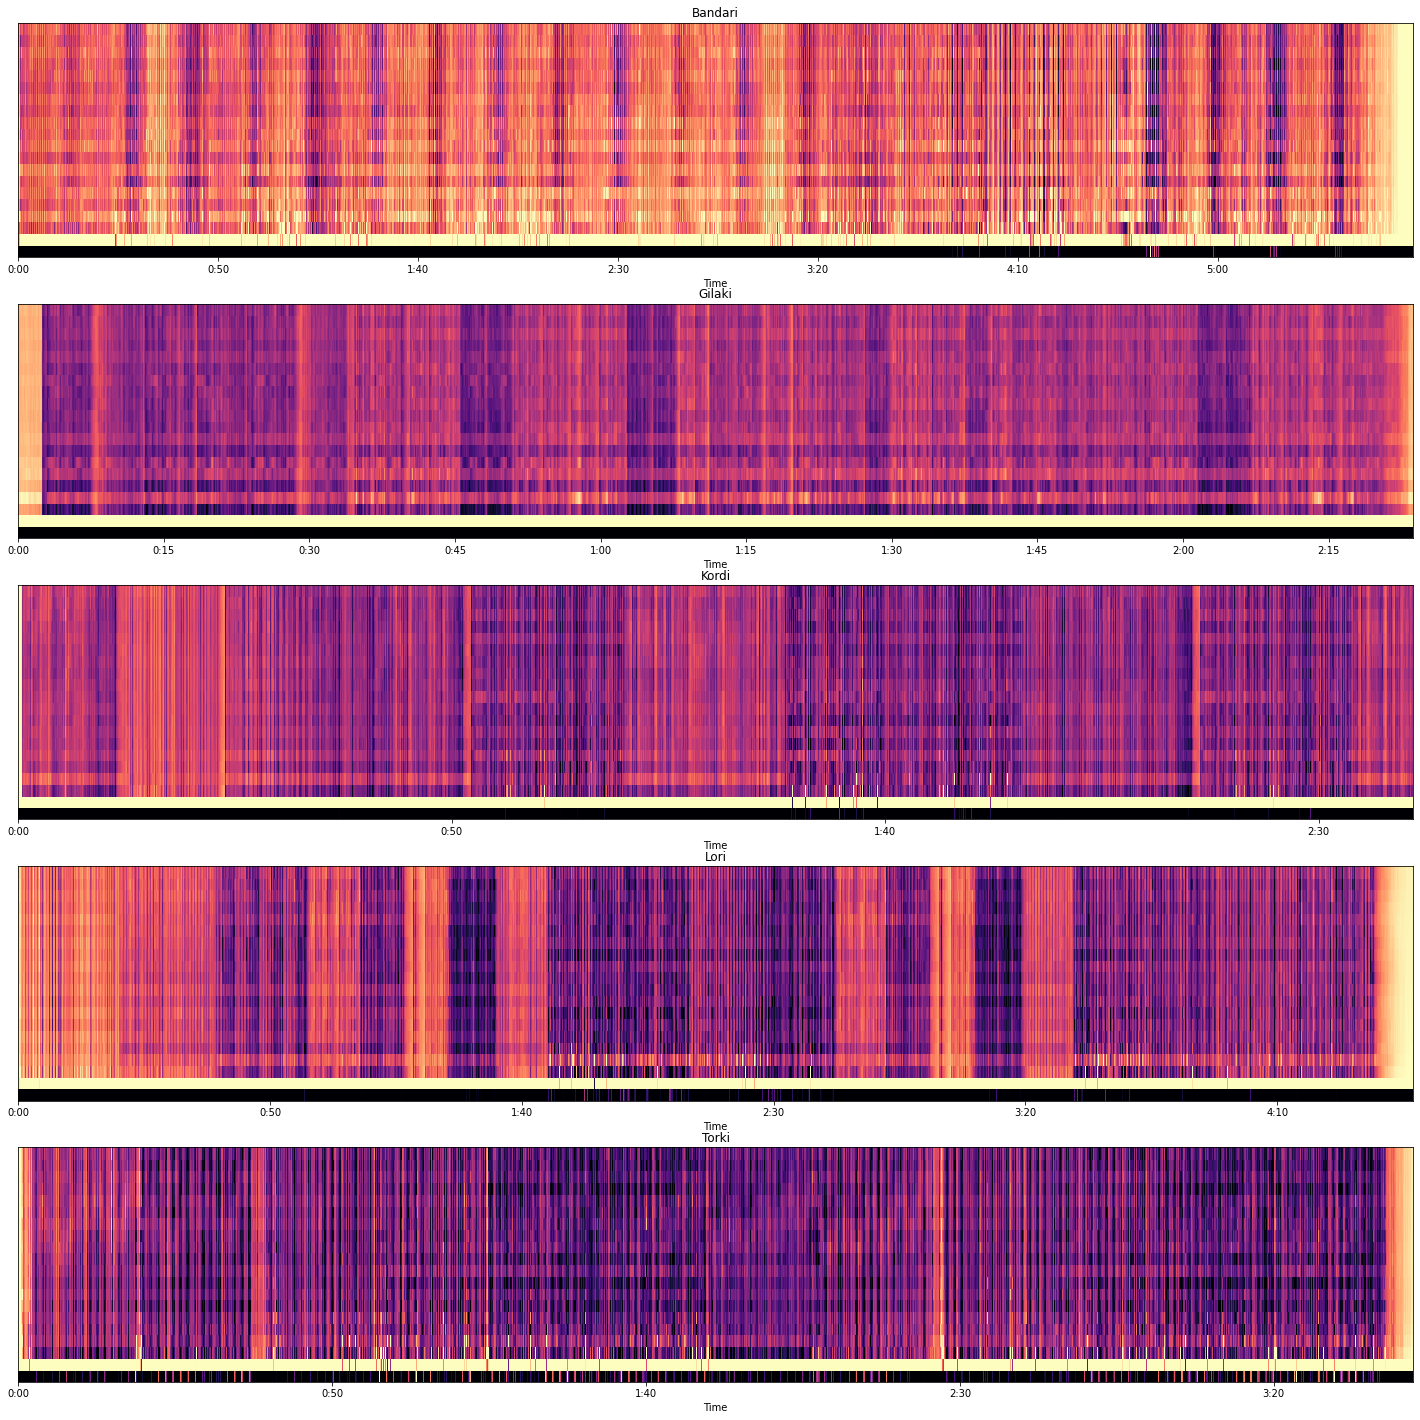

In [72]:
plt.figure(figsize=(25, 25))
categories = ["Bandari", "Gilaki", "Kordi", "Lori", "Torki"]
for i in range(5):
    x, sr = librosa.load("/content/" + categories[i] + ".wav")
    plt.subplot(5, 1, i + 1)
    mfccs = librosa.feature.mfcc(x, sr=sr)
    librosa.display.specshow(minmax_scale(mfccs), sr=sr, x_axis='time')
    plt.title(categories[i])
plt.show()

## توابع پیدا کردن فایل های مشکل دار ،‌ جدا سازی و تیکه کردن آهنگ ها و استخراج ویژگی ها

In [ ]:
def createDirectoryIfDoesNotExists(path):
    if not os.path.exists(path):
        os.makedirs(path)

def findBadFiles(data_path, bad_files):
    result = []
    for subdir, dirs, files in os.walk(DATA_PATH):
        for file in tqdm(files):
            filePath = DATA_PATH + os.sep + subdir.split(os.sep)[-1] + os.sep + file   

            try:
              audio = MP3(filePath)
              result.append(int(audio.info.length))
            except:
              bad_files.append(filePath)
              pass
    return result

def splitMusics(data_path, final_path, category, lengthInMilliseconds):
    print(f"Splitting {category}")
    result = []
    category_path = join(data_path, category)

    files = [f for f in listdir(category_path) if isfile(join(category_path, f))]

    for file in tqdm(files):
        splittedFile = file.split('.')
        fileName = ".".join(splittedFile[:-1])

        filePath = join(category_path, file)

        if(filePath in bad_files):
          continue

        sound = AudioSegment.from_file(filePath)

        soundLength = len(sound)

        numberOfParts = soundLength // lengthInMilliseconds
        loss = soundLength - numberOfParts * lengthInMilliseconds
        skipEnd = loss // 2
        skipStart = loss - skipEnd

        start = skipStart + 1
        for i in range(numberOfParts):
            partFilePath = join(final_path, category, fileName + "_" + str(i+1) + ".wav")
            part = sound[start: start+lengthInMilliseconds+1]

            createDirectoryIfDoesNotExists(join(final_path, category))

            part.export(partFilePath , format="wav")
            start = start+lengthInMilliseconds+1          


def prepare_dataset(data_path, category):
    SAMPLES_TO_CONSIDER = 22050 * 30

    label = {"Bandari":0, "Gilaki":1, "Kordi":2, "Lori":3, "Torki":4}
    category_path = join(data_path, category)

    files = [f for f in listdir(category_path) if isfile(join(category_path, f))]

    print(f"Processing {category}")

    for file in tqdm(files):

      file_path = join(category_path, file)

      signal, sr = librosa.load(file_path)

      if len(signal) >= SAMPLES_TO_CONSIDER:
          signal = signal[:SAMPLES_TO_CONSIDER]

          features = []

          #zero crossing
          zero_crossing = librosa.zero_crossings(signal, pad = False)
          features.append(zero_crossing.sum()) # f0

          #spectral centroids
          spectral_centroids = librosa.feature.spectral_centroid(signal, sr=sr)[0]
          features.append(spectral_centroids.mean()) # f1
          features.append(spectral_centroids.var()) # f2

          #spectral rolloff
          spectral_rolloff = librosa.feature.spectral_rolloff(signal+0.01, sr=sr)[0]
          features.append(spectral_rolloff.mean()) # f3
          features.append(spectral_rolloff.var()) # f4

          #Chroma Frequencies
          chromagram = librosa.feature.chroma_stft(signal, sr=sr)
          features += chromagram.mean(axis=1).tolist() # f5 - f16
          features += chromagram.var(axis=1).tolist() # f17 - f28
          
          #Mel-Frequency Cepstral Coefficients
          MFCCs = librosa.feature.mfcc(signal)
          features += MFCCs.mean(axis=1).tolist() # f29 - f48
          features += MFCCs.var(axis=1).tolist() # f49 - f68

          # add label
          features.append(label[category])

          data.append(features)

In [ ]:
!unrar x "/content/drive/MyDrive/ML_course_data_gathering_Arash_Rasouli/ML_Data G1.rar"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal

Cannot open /content/drive/MyDrive/ML_course_data_gathering_Arash_Rasouli/ML_Data G1.rar
No such file or directory
No files to extract


## پیدا کردن فایل های مشکل دار

In [ ]:
bad_files = []
DATA_PATH = "/content/ML_Data G1"
findBadFiles(DATA_PATH, bad_files)
print("\n")
print(bad_files)

0it [00:00, ?it/s]
100%|██████████| 289/289 [00:00<00:00, 805.50it/s]



['/content/ML_Data G1/Lori/89.mp3', '/content/ML_Data G1/Lori/156.mp3', '/content/ML_Data G1/Bandari/22.mp3', '/content/ML_Data G1/Torki/231.mp3', '/content/ML_Data G1/Torki/104.mp3']


## استحراج ویژگی ها برای هر دسته و ذخیره سازی آن ها در فایل های متفاوت

In [ ]:
data_path = "/content/ML_Data G1"
final_path = "/content/all"

csv_header = ["f"+str(i) for i in range(69)] + ["label"]
csv_header = ",".join(csv_header)

categories = ["Bandari", "Gilaki", "Kordi", "Lori", "Torki"]

for category in categories:
  data = []

  splitMusics(data_path, final_path, category, 30000)
  prepare_dataset(final_path, category)
  shutil.rmtree(join(final_path, category))

  csv_path = "/content/drive/MyDrive/ML_Data/" + category + "_30" + '.csv'

  np.savetxt(csv_path, data, delimiter=",", header=csv_header, comments="")

Splitting Torki


100%|██████████| 289/289 [06:03<00:00,  1.26s/it]


Processing Torki


100%|██████████| 287/287 [1:02:36<00:00, 13.09s/it]


## ادغام کردن فایل ها و ساخت یک فایل جامع

In [ ]:
Bandari = pd.read_csv('/content/drive/MyDrive/ML_Data/Bandari_30.csv')
Gilaki = pd.read_csv('/content/drive/MyDrive/ML_Data/Gilaki_30.csv')
Kordi = pd.read_csv('/content/drive/MyDrive/ML_Data/Kordi_30.csv')
Lori = pd.read_csv('/content/drive/MyDrive/ML_Data/Lori_30.csv')
Torki = pd.read_csv('/content/drive/MyDrive/ML_Data/Torki_30.csv')

all = pd.concat([Bandari, Gilaki, Kordi, Lori, Torki])
all.reset_index()

all.to_csv('/content/drive/MyDrive/ML_Data/ML_Project_Data_30.csv')